In [1]:
dataset_url = '../data/image_classification/'

In [2]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

## Load data

In [3]:
data = pd.read_csv(dataset_url + 'train.csv', on_bad_lines='skip')
data.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Analyse générale du dataset

In [4]:
data.shape

(29996, 3)

In [6]:
# Transformer la target multi-classes en liste
data['Targets'] = data['Labels'].apply(lambda x: x.split(' '))
data.head()

,ImageID,Labels,Caption,Targets
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,[1]
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,"[1, 19]"
2,2.jpg,1,They are brave for riding in the jungle on tho...,[1]
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,"[8, 3, 13]"
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,"[8, 3, 7]"


## Analyse de la variable cible 

In [15]:
# Liste des classes et leurs nombres d'occurences quand ils sont uniques
data[data['Targets'].apply(len) == 1].groupby(data['Targets'].apply(lambda x: str(x))).count()

,ImageID,Labels,Caption,Targets
Targets,,,,
['1'],14073,14073,14073,14073
['10'],186,186,186,186
['11'],187,187,187,187
['13'],200,200,200,200
['14'],42,42,42,42
['15'],289,289,289,289
['16'],673,673,673,673
['17'],975,975,975,975
['18'],585,585,585,585


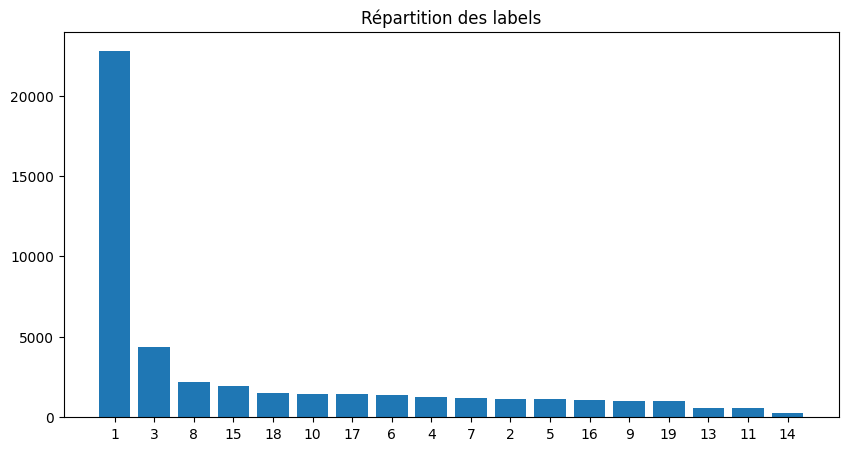

In [ ]:
# Nombre d'occurences de chaque classe

label_counts = pd.DataFrame(data['Targets'].explode().value_counts()).reset_index()
label_counts.columns = ['Label', 'Count']
label_counts['Proportion'] = label_counts['Count'] / label_counts['Count'].sum()

plt.figure(figsize=(10, 5))
plt.bar(label_counts['Label'], label_counts['Count'])
plt.title('Répartition des labels')
plt.show()

* Possibilité de sous-échantillonner les classes majoritaires (ici, la classe 1)
    * Reduire le plus de donnees avec pour label 1 uniquement (garder un peu pour pouvoir identifier la classe 1 aussi)
* Et sur-échantillonner les classes minoritaires
    * Generer des donnees artificielles en evident ce qui ont la classe 1 dans leurs labels

## Exploration des images

Classes found: ['1' '19' '8' '3' '13' '7' '5' '4' '18' '15' '6' '9' '17' '10' '2' '16'
 '14' '11']


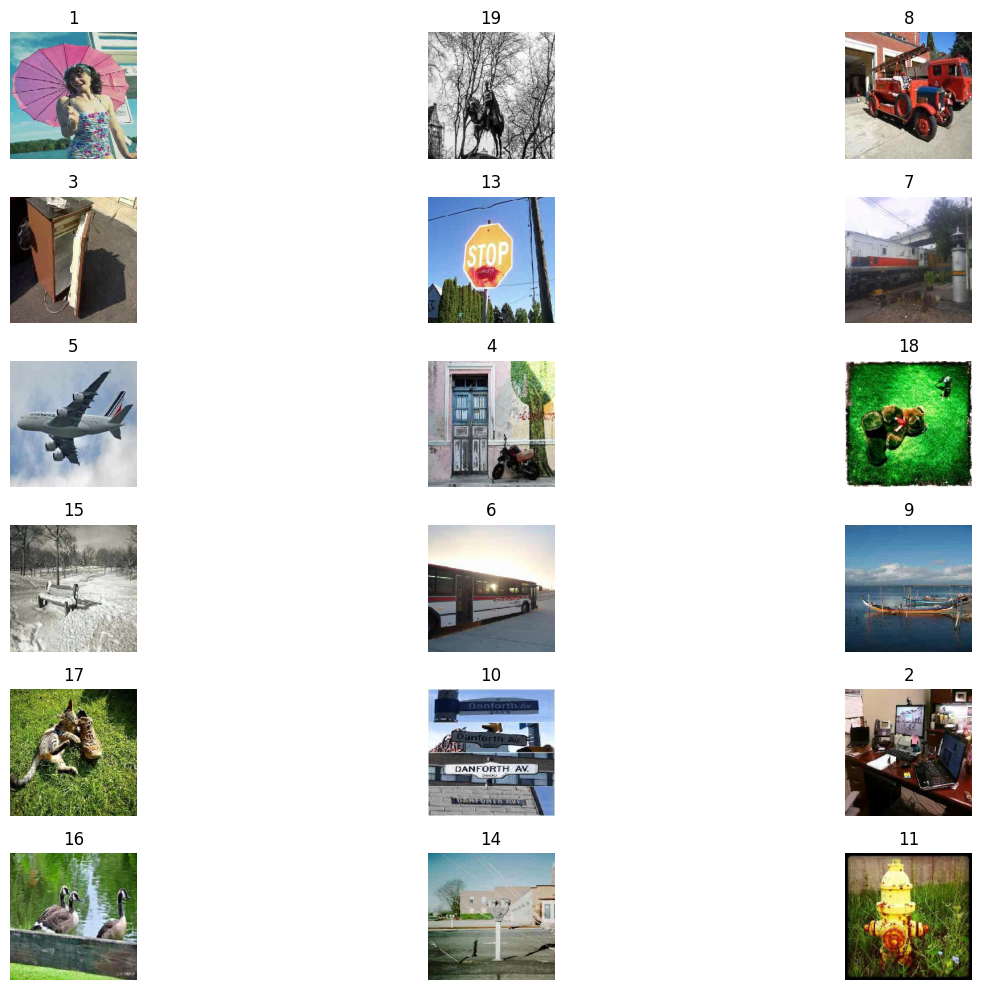

In [55]:
# List classes available in the dataset
classes = data['Targets'].explode().unique()
print("Classes found:", classes)

num_cols = 3
num_rows = 6

plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    image = data[data['Targets'].apply(lambda x: x==[cls])]
    if not image.empty:
        img = load_img(dataset_url + 'data/' + image.iloc[0]['ImageID'], target_size=(224, 224))
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        
        plt.savefig('../output/visualize_classes.png')
    
plt.tight_layout()
plt.show()

In [18]:
# temp = data[data.apply(lambda x: '1' not in x['Targets'], axis=1)]  # Supprime toutes les lignes avec '1' dans les targets
temp = data[data.apply(lambda x: x['Targets'] != ['1'], axis=1)] # Supprime toutes les lignes avec seulement '1' comme target

temp['Targets'].explode().value_counts()

Targets
1     8721
3     4364
8     2210
15    1934
18    1525
10    1470
17    1430
6     1395
4     1272
7     1221
2     1164
5     1132
16    1099
9     1042
19    1020
13     605
11     603
14     252
Name: count, dtype: int64

## Data preprocessing

* Split les données en train, val et test
* Augmenter les données pour les classes minoritaires dans l'ensemble de train

In [5]:
temp = data.copy()
temp.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [6]:
train_len = 0.7
val_len = 0.15
test_len = 0.15
random_state = 42

# Création du DataFrame
df = pd.DataFrame(temp)

# Conversion des labels en listes d'entiers
df['Labels'] = df['Labels'].apply(lambda x: list(map(int, x.split())))

# Séparation des features et des labels
X = df[['ImageID', 'Caption']]
y = df['Labels']

# Conversion des labels en format binaire (multilabel-indicator)
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Division stratifiée en ensembles d'entraînement et de test
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_len, random_state=random_state)
for train_index, test_index in msss.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]

# Division de l'ensemble d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_len/(train_len+val_len), random_state=random_state)

# Affichage des tailles des ensembles
print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (21004, 2)
Validation size: (4501, 2)
Test size: (4491, 2)


In [7]:
# Convertir en DataFrame
y_train_df = pd.DataFrame(y_train, columns=mlb.classes_)
y_val_df = pd.DataFrame(y_val, columns=mlb.classes_)
y_test_df = pd.DataFrame(y_test, columns=mlb.classes_)

# Assurer l'alignement des index
X_train.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)

X_val.reset_index(drop=True, inplace=True)
y_val_df.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Concaténation propre
train_data = pd.concat([X_train, y_train_df], axis=1)
val_data = pd.concat([X_val, y_val_df], axis=1)
test_data = pd.concat([X_test, y_test_df], axis=1)

# Vérifier la taille finale
train_data.shape, val_data.shape, test_data.shape

((21004, 20), (4501, 20), (4491, 20))

In [9]:
train_data.head()

,ImageID,Caption,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,21999.jpg,A couple of men standing next to a train on a ...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,10911.jpg,An empty bench sits next to a river.,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11565.jpg,Three people in orange vests watch a space shu...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23495.jpg,A traffic light with a street sigh hanging fro...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,26902.jpg,A man standing on a tennis court holding a rac...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


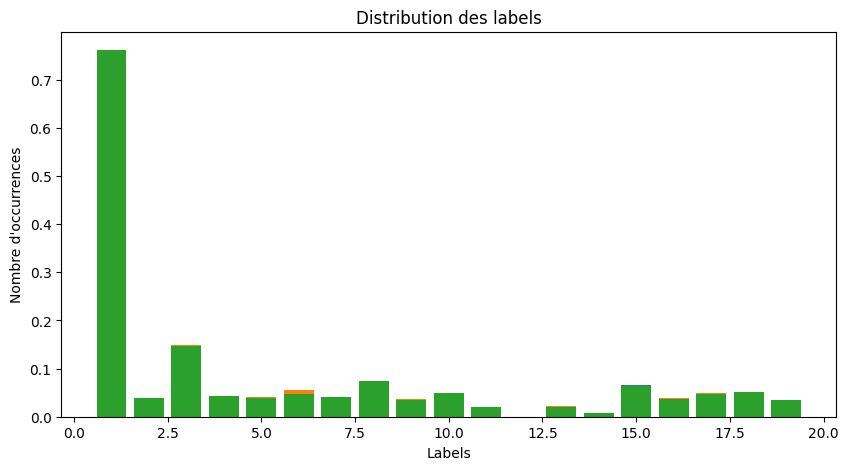

In [ ]:
# Calculer la distribution des labels
label_distribution = train_data.iloc[:, 2:].sum()
label_distribution_val = val_data.iloc[:, 2:].sum()
label_distribution_test = test_data.iloc[:, 2:].sum()

# Afficher la distribution des labels
plt.figure(figsize=(10, 5))
plt.bar(label_distribution.index, label_distribution.values/len(train_data), alpha=0.7, label='Train', color='blue')
plt.bar(label_distribution_val.index, label_distribution_val.values/len(val_data), alpha=0.7, label='Validation', color='green')
plt.bar(label_distribution_test.index, label_distribution_test.values/len(test_data), alpha=0.7, label='Test', color='red')
plt.title('Distribution des labels')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import albumentations as A
import cv2
from functools import partial
from tqdm import tqdm


class MultiLabelDataAugmentation:
    def __init__(self, 
                 dataset_path: str, 
                 df: pd.DataFrame, 
                 output_path: str,
                 num_workers: int = None):

        self.dataset_path = dataset_path
        self.output_path = output_path
        
        # Définir le nombre de workers (défaut: nombre de coeurs disponibles - 1)
        self.num_workers = num_workers or (os.cpu_count() - 1)
        
        # Charger les labels
        self.labels_df = df.copy()
        
        # Créer le dossier de sortie s'il n'existe pas
        os.makedirs(output_path, exist_ok=True)
    
    def safe_load_image(self, image_path: str) -> np.ndarray:
        try:
            # Charger l'image en couleur
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            if image is None:
                raise ValueError(f"Impossible de charger l'image {image_path}")
            
            # Convertir de BGR à RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            return image
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {image_path}: {e}")
            return None
    
    def create_safe_transforms(self, image: np.ndarray) -> A.Compose:
        height, width = image.shape[:2]
        
        # Stratégies pour les petites images
        transforms_list = []
        
        # 1. Si l'image est très petite, on évite le crop
        if height < 224 or width < 224:
            transforms_list.extend([
                A.PadIfNeeded(
                    min_height=224, 
                    min_width=224, 
                    border_mode=cv2.BORDER_CONSTANT, 
                    value=[0, 0, 0]  # Padding noir
                ),
                A.Resize(height=224, width=224)
            ])
        else:
            # Pour les images plus grandes
            transforms_list.extend([
                A.RandomCrop(height=min(height, 224), width=min(width, 224)),
                A.Resize(height=224, width=224)
            ])
        
        # Transformations communes
        transforms_list.extend([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.3),
            A.Perspective(p=0.3)
        ])
        
        return A.Compose(transforms_list)
    
    def extraire_labels_minoritaires(self, 
                                     seuil_pourcentage: float = 10) -> List[int]:
        # Colonnes de labels (excluant 'ImageID' et 'Caption')
        label_columns = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption']]
        label_percentages = self.labels_df[label_columns].sum() / len(self.labels_df) * 100
        
        return [label for label, percentage in label_percentages.items() if percentage < seuil_pourcentage]
    
    def augmenter_image_unique(self, row: pd.Series, nb_augmentations: int = 5) -> List[Dict]:
        """
        Augmente une seule image et retourne les informations des images augmentées
        """
        image_path = os.path.join(self.dataset_path, row['ImageID'])
        
        # Charger l'image de manière sécurisée
        image = self.safe_load_image(image_path)
        
        if image is None:
            return []
        
        # Créer des transformations sécurisées
        transforms = self.create_safe_transforms(image)
        
        augmentations_resultats = []
        
        # Générer des augmentations
        for i in range(nb_augmentations):
            try:
                augmented = transforms(image=image)
                augmented_image = augmented['image']
                
                # Nom de fichier pour l'image augmentée
                nom_base = os.path.splitext(row['ImageID'])[0]
                nouveau_nom = f"{nom_base}_aug_{i+1}.jpg"
                chemin_sortie = os.path.join(self.output_path, nouveau_nom)
                
                # Sauvegarder l'image
                cv2.imwrite(chemin_sortie, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                
                # Préparer les données pour le nouveau DataFrame 
                nouvelle_ligne = row.copy()
                nouvelle_ligne['ImageID'] = nouveau_nom
                
                augmentations_resultats.append(nouvelle_ligne)
            
            except Exception as e:
                print(f"Erreur lors de l'augmentation de {row['ImageID']}: {e}")
        
        return augmentations_resultats
    
    def augmenter_labels_minoritaires(self, 
                                      seuil_pourcentage: float = 10, 
                                      nb_augmentations: int = 5):
        
        # Identifier les labels minoritaires
        labels_minoritaires = self.extraire_labels_minoritaires(seuil_pourcentage)
        print("Labels minoritaires identifiés :", labels_minoritaires)
        labels_majoritaires = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption'] and col not in labels_minoritaires]
        
        # Filtrer les images avec les labels minoritaires
        images_minoritaires = self.labels_df[
            (self.labels_df[labels_minoritaires].sum(axis=1) > 0) & (self.labels_df[labels_majoritaires].sum(axis=1) == 0)
        ]
        
        # Augmentation sans multiprocessing
        nouvelles_images = []
        for index, row in tqdm(images_minoritaires.iterrows(), total=len(images_minoritaires), desc="Augmentation des images"):
            # print(f"Traitement de l'image {row['ImageID']} ({index+1}/{len(images_minoritaires)})")
            augmentations = self.augmenter_image_unique(row)
            nouvelles_images.extend(augmentations)
        
        if nouvelles_images:
            self.labels_df = pd.concat([self.labels_df, pd.DataFrame(nouvelles_images)], ignore_index=True)
        
        # Sauvegarder le nouveau CSV
        self.labels_df.to_csv(os.path.join(self.output_path, 'augmented_labels.csv'), index=False)
        
        print(f"Augmentation terminée. {len(self.labels_df)} images dans le nouveau dataset.")
    
    def calculer_repartition_labels(self) -> Dict[str, float]:
        label_columns = [col for col in self.labels_df.columns if col not in ['ImageID', 'Caption']]
        label_percentages = self.labels_df[label_columns].sum() / len(self.labels_df) * 100
        
        return label_percentages.to_dict()

In [24]:
# Exemple d'utilisation
augmenteur = MultiLabelDataAugmentation(
    dataset_path=dataset_url+'data', 
    df=train_data,
    output_path='../augmented_images/train',
    num_workers=1  # Utilise automatiquement le nombre de coeurs disponibles - 1
)

# Afficher la répartition des labels
print("Répartition des labels :")
print(augmenteur.calculer_repartition_labels())

# Augmenter les labels minoritaires
augmenteur.augmenter_labels_minoritaires(
    seuil_pourcentage=20,  # Labels avec moins de 5% des données 
    nb_augmentations=15     # 5 augmentations par image
)

Répartition des labels :
{1: 76.11407350980765, 2: 3.946867263378404, 3: 14.45915063797372, 4: 4.218244143972576, 5: 3.680251380689392, 6: 4.470577032946106, 7: 4.075414206817749, 8: 7.370024757189107, 9: 3.442201485431346, 10: 4.922871833936393, 11: 2.01390211388307, 13: 1.9900971243572652, 14: 0.852218625023805, 15: 6.5416111216911075, 16: 3.6231194058274614, 17: 4.713387926109312, 18: 5.099028756427347, 19: 3.446962483336508}
Labels minoritaires identifiés : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]


Augmentation des images:   0%|          | 0/5017 [00:00<?, ?it/s]

C:\Users\jforc\AppData\Local\Temp\ipykernel_71540\2594743412.py:55: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
Augmentation des images: 100%|██████████| 5017/5017 [02:24<00:00, 34.78it/s]


Augmentation terminée. 46089 images dans le nouveau dataset.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

def visualiser_augmentations(
    dataset_path: str, 
    csv_augmente_path: str, 
    output_path: str = None
):
    """
    Visualise les images originales et leurs augmentations pour chaque label.
    
    :param dataset_path: Chemin du dossier contenant les images originales
    :param csv_augmente_path: Chemin du CSV généré après augmentation
    :param output_path: Chemin de sauvegarde optionnel des visualisations
    """
    # Charger le CSV augmenté
    df_augmente = pd.read_csv(csv_augmente_path)
    
    # Colonnes de labels (excluant 'ImageID' et 'Caption')
    label_columns = [col for col in df_augmente.columns if col not in ['ImageID', 'Caption']]
    
    # Créer un dossier de sortie si spécifié
    if output_path:
        os.makedirs(output_path, exist_ok=True)
    
    # Pour chaque label
    for label in label_columns:
        # Trouver les augmentations de ce label
        df_label = df_augmente[df_augmente[label] == 1]
        
        # Images originales vs augmentées
        originales = df_label[~df_label['ImageID'].str.contains('aug')]
        augmentees = df_label[df_label['ImageID'].str.contains('aug')]
        
        # Associer les originales et leurs augmentations
        matched_pairs = []
        for _, orig_row in originales.iterrows():
            base_name = os.path.splitext(orig_row['ImageID'])[0]
            aug_matching = augmentees[augmentees['ImageID'].str.startswith(base_name + '_aug')]
            
            for _, aug_row in aug_matching.iterrows():
                matched_pairs.append((orig_row['ImageID'], aug_row['ImageID']))
        
        # Limiter à 5 paires maximum
        matched_pairs = matched_pairs[:2]
        
        # Visualisation
        plt.figure(figsize=(15, 3 * len(matched_pairs)))
        plt.suptitle(f'Augmentations pour le label "{label}"', fontsize=16)
        
        for i, (orig_name, aug_name) in enumerate(matched_pairs):
            # Charger image originale
            orig_path = os.path.join('../data/image_classification/data', orig_name)
            orig_image = cv2.imread(orig_path)
            orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
            
            # Charger image augmentée
            aug_path = os.path.join(os.path.dirname(csv_augmente_path), aug_name)
            aug_image = cv2.imread(aug_path)
            aug_image = cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB)
            
            # Afficher l'image originale
            plt.subplot(len(matched_pairs), 2, i*2 + 1)
            plt.title('Image Originale')
            plt.imshow(orig_image)
            plt.axis('off')
            
            # Afficher l'image augmentée
            plt.subplot(len(matched_pairs), 2, i*2 + 2)
            plt.title('Image Augmentée')
            plt.imshow(aug_image)
            plt.axis('off')
        
        # Sauvegarder ou afficher
        if output_path:
            plt.savefig(output_path+f'augmentations_{label}.png')
            plt.close()
        else:
            plt.show()

# Exemple d'utilisation
visualiser_augmentations(
    dataset_path='../augmented_images/train',
    csv_augmente_path='../augmented_images/train/augmented_labels.csv',
    output_path='../output'
)

In [ ]:
train = pd.read_csv('../augmented_images/train/augmented_labels.csv')

,ImageID,Caption,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19
0,21999.jpg,A couple of men standing next to a train on a ...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,10911.jpg,An empty bench sits next to a river.,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11565.jpg,Three people in orange vests watch a space shu...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23495.jpg,A traffic light with a street sigh hanging fro...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,26902.jpg,A man standing on a tennis court holding a rac...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


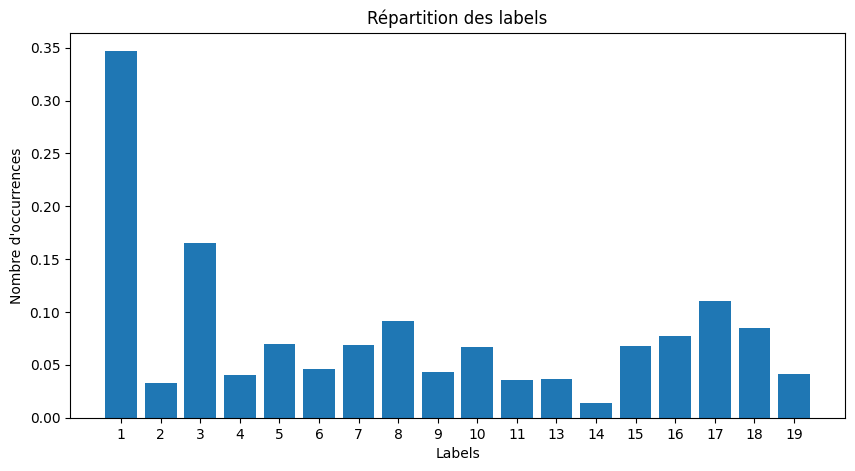

In [ ]:
label_counts = train.iloc[:, 2:].sum()

# Afficher la répartition des labels
plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values/len(train))
plt.title('Répartition des labels')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.show()

## Modeling

In [8]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

class MemoryEfficientMultiLabelDataset:
    def __init__(self, csv_path, image_dir, target_size=(224, 224), df=None):
        """
        Initialise le dataset multi-labels avec chargement paresseux
        """
        self.csv_path = csv_path
        self.image_dir = image_dir
        self.target_size = target_size
        
        # Charger les données
        print("Chargement des données...")
        if df is not None:
            self.df = pd.DataFrame(df)
        else:
            self.df = pd.read_csv(csv_path)
        print(f"Nombre total d'images: {len(self.df)}")
        
        # Colonnes de labels (exclure 'ImageID' et 'Caption')
        self.label_columns = [col for col in self.df.columns if col not in ['ImageID', 'Caption']]
        self.num_classes = len(self.label_columns)
    
    def _load_and_preprocess_image(self, image_filename):
        """
        Charge et prétraite une image depuis un fichier
        """
        # Gestion conditionnelle des chemins d'image
        if tf.strings.regex_full_match(image_filename, ".*_aug.*"):
            image_path = tf.strings.join([self.image_dir, image_filename], separator="/")
        else:
            image_path = tf.strings.join(["../data/image_classification/data", image_filename], separator="/")
        
        # Lire l'image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # Redimensionner
        img = tf.image.resize(img, self.target_size)
        
        # Normaliser
        img = tf.cast(img, tf.float32) / 255.0
        
        return img
    
    def create_dataset(self, batch_size=32, shuffle=True):
        """
        Crée un dataset TensorFlow avec chargement à la volée
        """
        print("Préparation du dataset TensorFlow...")
        
        # Convertir les chemins d'images et labels en tensors
        image_filenames = self.df['ImageID'].values
        labels = self.df[self.label_columns].values.astype('float32')
        
        # Créer un dataset initial
        ds_filenames = tf.data.Dataset.from_tensor_slices(image_filenames)
        ds_labels = tf.data.Dataset.from_tensor_slices(labels)
        dataset = tf.data.Dataset.zip((ds_filenames, ds_labels))
        
        # Appliquer le chargement des images
        dataset = dataset.map(
            lambda filename, label: (self._load_and_preprocess_image(filename), label),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Vérifier un échantillon pour s'assurer que les formes sont correctes
        for img, label in dataset.take(1):
            print(f"Forme d'une image: {img.shape}")
            print(f"Forme d'un label: {label.shape}")
        
        # Configuration de la forme explicite
        dataset = dataset.map(
            lambda img, label: (
                tf.ensure_shape(img, [self.target_size[0], self.target_size[1], 3]), 
                tf.ensure_shape(label, [self.num_classes])
            )
        )
        
        # Mélanger le dataset
        if shuffle:
            dataset = dataset.shuffle(buffer_size=min(len(self.df), 10000))
        
        # Création des batchs
        dataset = dataset.batch(batch_size)
        
        # Optimisation
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        print("Dataset TensorFlow créé avec succès.")
        return dataset
    
    def print_dataset_info(self):
        """
        Affiche des informations sur le dataset
        """
        print("Informations sur le Dataset:")
        print("-" * 30)
        print(f"Nombre total d'images: {len(self.df)}")
        print(f"Taille des images: {self.target_size}")
        print(f"Nombre de classes: {len(self.label_columns)}")
        
        # Distribution des labels
        print("\nDistribution des labels:")
        label_sums = self.df[self.label_columns].sum()
        for label, count in label_sums.items():
            print(f"{label}: {count} (proportion: {count/len(self.df):.2%})")

In [ ]:
# Chemins à adapter
csv_path = '../augmented_images/train/augmented_labels.csv'
image_dir = '../augmented_images/train/'

# Initialiser le dataset
dataset = MemoryEfficientMultiLabelDataset(csv_path, image_dir)

# Afficher les informations du dataset
dataset.print_dataset_info()

# Créer les datasets TensorFlow
train_dataset = dataset.create_dataset(batch_size=128)

Chargement des données...
Nombre total d'images: 46089
Informations sur le Dataset:
------------------------------
Nombre total d'images: 46089
Taille des images: (224, 224)
Nombre de classes: 18

Distribution des labels:
1: 15987 (proportion: 34.69%)
2: 1529 (proportion: 3.32%)
3: 7627 (proportion: 16.55%)
4: 1846 (proportion: 4.01%)
5: 3213 (proportion: 6.97%)
6: 2134 (proportion: 4.63%)
7: 3181 (proportion: 6.90%)
8: 4198 (proportion: 9.11%)
9: 2013 (proportion: 4.37%)
10: 3079 (proportion: 6.68%)
11: 1628 (proportion: 3.53%)
13: 1693 (proportion: 3.67%)
14: 644 (proportion: 1.40%)
15: 3109 (proportion: 6.75%)
16: 3556 (proportion: 7.72%)
17: 5100 (proportion: 11.07%)
18: 3906 (proportion: 8.47%)
19: 1904 (proportion: 4.13%)
Préparation du dataset TensorFlow...
Forme d'une image: (224, 224, 3)
Forme d'un label: (18,)
Dataset TensorFlow créé avec succès.


In [10]:
image_dir = '../augmented_images/train/'

# Initialiser le dataset
val_set = MemoryEfficientMultiLabelDataset(csv_path, image_dir, df=val_data)

# Afficher les informations du dataset
val_set.print_dataset_info()

# Créer les datasets TensorFlow
val_dataset = dataset.create_dataset(batch_size=128)

Chargement des données...
Nombre total d'images: 4501
Informations sur le Dataset:
------------------------------
Nombre total d'images: 4501
Taille des images: (224, 224)
Nombre de classes: 18

Distribution des labels:
1: 3387 (proportion: 75.25%)
2: 160 (proportion: 3.55%)
3: 672 (proportion: 14.93%)
4: 195 (proportion: 4.33%)
5: 189 (proportion: 4.20%)
6: 247 (proportion: 5.49%)
7: 182 (proportion: 4.04%)
8: 330 (proportion: 7.33%)
9: 163 (proportion: 3.62%)
10: 215 (proportion: 4.78%)
11: 90 (proportion: 2.00%)
13: 96 (proportion: 2.13%)
14: 35 (proportion: 0.78%)
15: 270 (proportion: 6.00%)
16: 173 (proportion: 3.84%)
17: 225 (proportion: 5.00%)
18: 225 (proportion: 5.00%)
19: 143 (proportion: 3.18%)
Préparation du dataset TensorFlow...
Forme d'une image: (224, 224, 3)
Forme d'un label: (18,)
Dataset TensorFlow créé avec succès.


In [13]:
image_dir = '../augmented_images/train/'

# Initialiser le dataset
test_set = MemoryEfficientMultiLabelDataset(csv_path, image_dir, df=test_data)

# Afficher les informations du dataset
test_set.print_dataset_info()

# Créer les datasets TensorFlow
test_dataset = dataset.create_dataset(batch_size=128)

Chargement des données...
Nombre total d'images: 4491
Informations sur le Dataset:
------------------------------
Nombre total d'images: 4491
Taille des images: (224, 224)
Nombre de classes: 18

Distribution des labels:
1: 3420 (proportion: 76.15%)
2: 175 (proportion: 3.90%)
3: 655 (proportion: 14.58%)
4: 191 (proportion: 4.25%)
5: 170 (proportion: 3.79%)
6: 209 (proportion: 4.65%)
7: 183 (proportion: 4.07%)
8: 332 (proportion: 7.39%)
9: 156 (proportion: 3.47%)
10: 221 (proportion: 4.92%)
11: 90 (proportion: 2.00%)
13: 91 (proportion: 2.03%)
14: 38 (proportion: 0.85%)
15: 290 (proportion: 6.46%)
16: 165 (proportion: 3.67%)
17: 215 (proportion: 4.79%)
18: 229 (proportion: 5.10%)
19: 153 (proportion: 3.41%)
Préparation du dataset TensorFlow...
Forme d'une image: (224, 224, 3)
Forme d'un label: (18,)
Dataset TensorFlow créé avec succès.


In [14]:
for x, y in train_dataset.take(1):
    print("Train")
    print(f"Forme des features: {x.shape}")
    print(f"Forme des labels: {y.shape}")
    
for x, y in val_dataset.take(1):
    print("Val")
    print(f"Forme des featutres: {x.shape}")
    print(f"Forme des labels: {y.shape}")
    
for x, y in test_dataset.take(1):
    print("Test")
    print(f"Forme des featutres: {x.shape}")
    print(f"Forme des labels: {y.shape}")

Train
Forme des features: (128, 224, 224, 3)
Forme des labels: (128, 18)
Val
Forme des featutres: (128, 224, 224, 3)
Forme des labels: (128, 18)
Test
Forme des featutres: (128, 224, 224, 3)
Forme des labels: (128, 18)


In [ ]:
# Exemple de modèle simple (à personnaliser)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(dataset.label_columns), activation='sigmoid')
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['F1Score', 'AUC']
)

In [16]:
# Entraînement (exemple)
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 356s 855ms/step - accuracy: 0.6014 - loss: 0.4958 - val_accuracy: 0.1969 - val_loss: 0.2523
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 1281s 4s/step - accuracy: 0.6088 - loss: 0.2127 - val_accuracy: 0.3753 - val_loss: 0.2187
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 375s 983ms/step - accuracy: 0.6383 - loss: 0.1922 - val_accuracy: 0.4122 - val_loss: 0.1952
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.6720 - loss: 0.1695 - val_accuracy: 0.4949 - val_loss: 0.1700
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 337s 881ms/step - accuracy: 0.7106 - loss: 0.1450 - val_accuracy: 0.6376 - val_loss: 0.1302


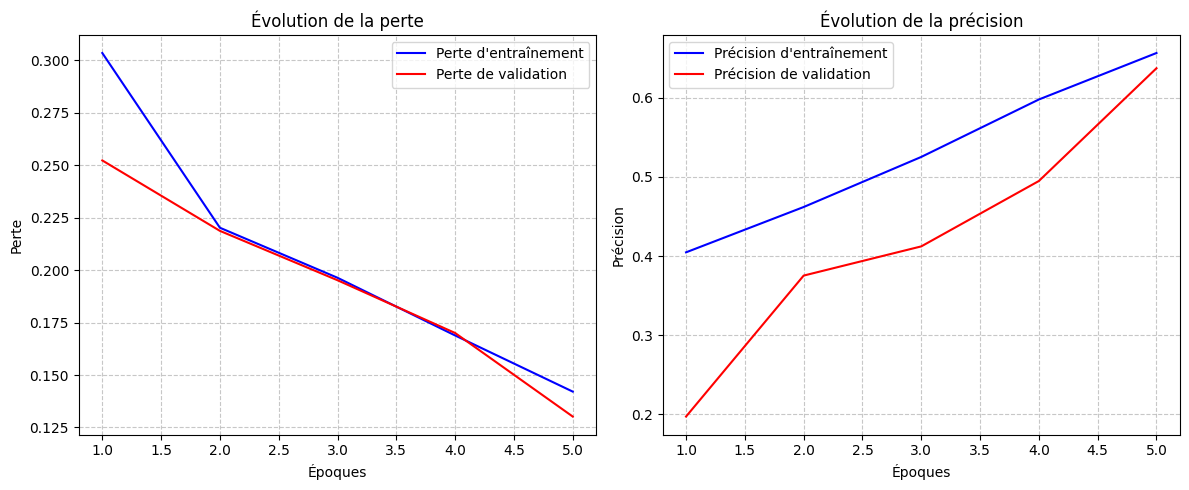

Perte d'entraînement finale: 0.1421
Perte de validation finale: 0.1302
Précision d'entraînement finale: 0.6569
Précision de validation finale: 0.6376


In [17]:
import matplotlib.pyplot as plt

# Récupérer l'historique d'entraînement
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history.get('accuracy', history.history.get('binary_accuracy', []))
val_accuracy = history.history.get('val_accuracy', history.history.get('val_binary_accuracy', []))
epochs = range(1, len(train_loss) + 1)

# Créer une figure avec deux sous-graphiques
plt.figure(figsize=(12, 5))

# Premier sous-graphique pour la loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r-', label='Perte de validation')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Deuxième sous-graphique pour l'accuracy (si disponible)
if train_accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Précision d\'entraînement')
    plt.plot(epochs, val_accuracy, 'r-', label='Précision de validation')
    plt.title('Évolution de la précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Afficher les valeurs finales
print(f"Perte d'entraînement finale: {train_loss[-1]:.4f}")
print(f"Perte de validation finale: {val_loss[-1]:.4f}")
if train_accuracy and val_accuracy:
    print(f"Précision d'entraînement finale: {train_accuracy[-1]:.4f}")
    print(f"Précision de validation finale: {val_accuracy[-1]:.4f}")

La metrique adaptée pour ce problème est **Mean Average Precision** car :
*  Nous faisons une classification multi-label
* On a un gros desequilibre au niveau des classes

En second, on peut utiliser **F1 score** car, on a la possibilité de gérer le desequilibre des classes en utilisant le macro F1 score.

Même si nous n'avons pas fait l'entrainement sur un grand nombre d'epoque, on peut vir que les courbes d'apprentissage et de perte evolues correctement. Donc notre modele apprend bien.

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

# Collect true labels and predictions
def get_true_pred_test(model, test_data): 
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        # y_true.extend(labels.numpy())
        y_true.extend(np.argmax(labels.numpy(), axis=1).tolist()) 
        y_pred.extend(np.argmax(preds, axis=1).tolist())
    return y_true, y_pred

def get_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Print a classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=dataset.label_columns))
    return cm 

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━

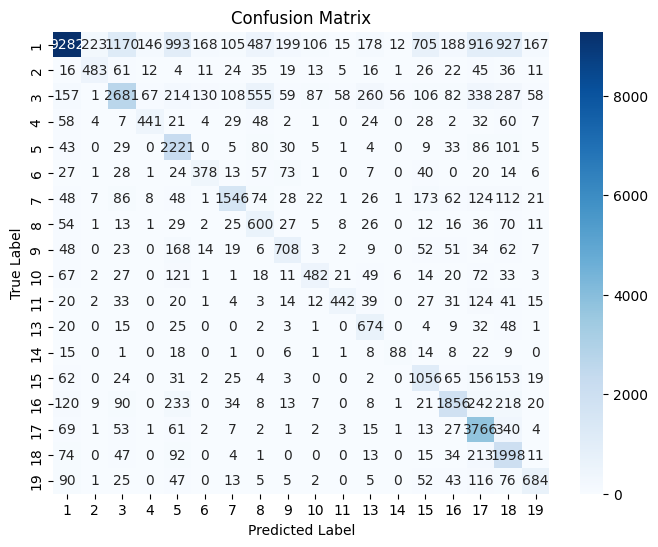

In [61]:
y_true, y_pred = get_true_pred_test(model, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, dataset.label_columns)

In [83]:
len(test_dataset)

361

In [ ]:
for images, labels in test_dataset.take(1):
    preds = model.predict(images)
    print(f"Vérification des formes des images: {images.shape}")
    print(f"Vérification des formes des labels: {labels.shape}")
    print(f"Vérification des formes des prédictions: {preds.shape}")
    print(f"Vérification des valeurs des labels: {labels.shape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Vérification des formes des images: (128, 224, 224, 3)
Vérification des formes des labels: (128, 18)
Vérification des formes des prédictions: (128, 18)
Vérification des valeurs des labels: [[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [81]:
y_test.shape, y_true.shape, y_pred.shape

((4491, 18), (4491, 18), (46089,))

In [79]:
nb = 0
for elt in y_test:
    for i in elt:
        if i == 1:
            nb += 1

print(nb)

6983


In [64]:
len(y_true), len(y_pred)

(4491, 46089)

In [70]:
from sklearn.metrics import average_precision_score
import numpy as np

# Convertir y_true et y_pred en tableaux numpy
y_true_np = np.array([t.numpy() if hasattr(t, 'numpy') else t for t in y_true])
y_pred_np = np.array([p.numpy() if hasattr(p, 'numpy') else p for p in y_pred])

print(f"Forme de y_true_np: {y_true_np.shape}")
print(f"Forme de y_pred_np: {y_pred_np.shape}")

# AP par classe
ap_per_class = {}
for i, col in enumerate(dataset.label_columns):
    try:
        ap = average_precision_score(y_true_np[:, i], y_pred_np[:, i])
        ap_per_class[col] = ap
        print(f"AP pour {col}: {ap:.4f}")
    except Exception as e:
        print(f"Erreur pour la classe {col}: {e}")

# mAP
if ap_per_class:
    mean_ap = np.mean(list(ap_per_class.values()))
    print(f"mAP: {mean_ap:.4f}")
else:
    print("Impossible de calculer mAP - aucune AP valide")

Forme de y_true_np: (4491, 18)
Forme de y_pred_np: (46089,)
Erreur pour la classe 1: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 2: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 3: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 4: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 5: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 6: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 7: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 8: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 9: too many indices for array: array is 1-dimensional, but 2 were indexed
Erreur pour la classe 10: too many indices for array: array is 1-dimensional